In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import detrend
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from shapely.geometry import Point, Polygon, LineString
import acoular
import pyproj
import geopandas as gpd
import contextily as ctx
import xml.dom.minidom
from io import BytesIO
from PIL import Image
import urllib.request
import pickle
from modules.das_IO import *
from modules.utils import *

# Construction data visualization

In [2]:
# Load DAS data
with open('data/das_data/construction.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
bandpass = {'fs':200, 'lp':1, 'hp':20, 'order':3}
rm_out = {'win_size':20, 'low':0.5, 'up':99.5}
x_axis_pp, t_axis_pp, data_pp = post_processing(data['data'], data['x_axis'], data['t_axis'], 
                                                bandpass=bandpass, rm_out=None)

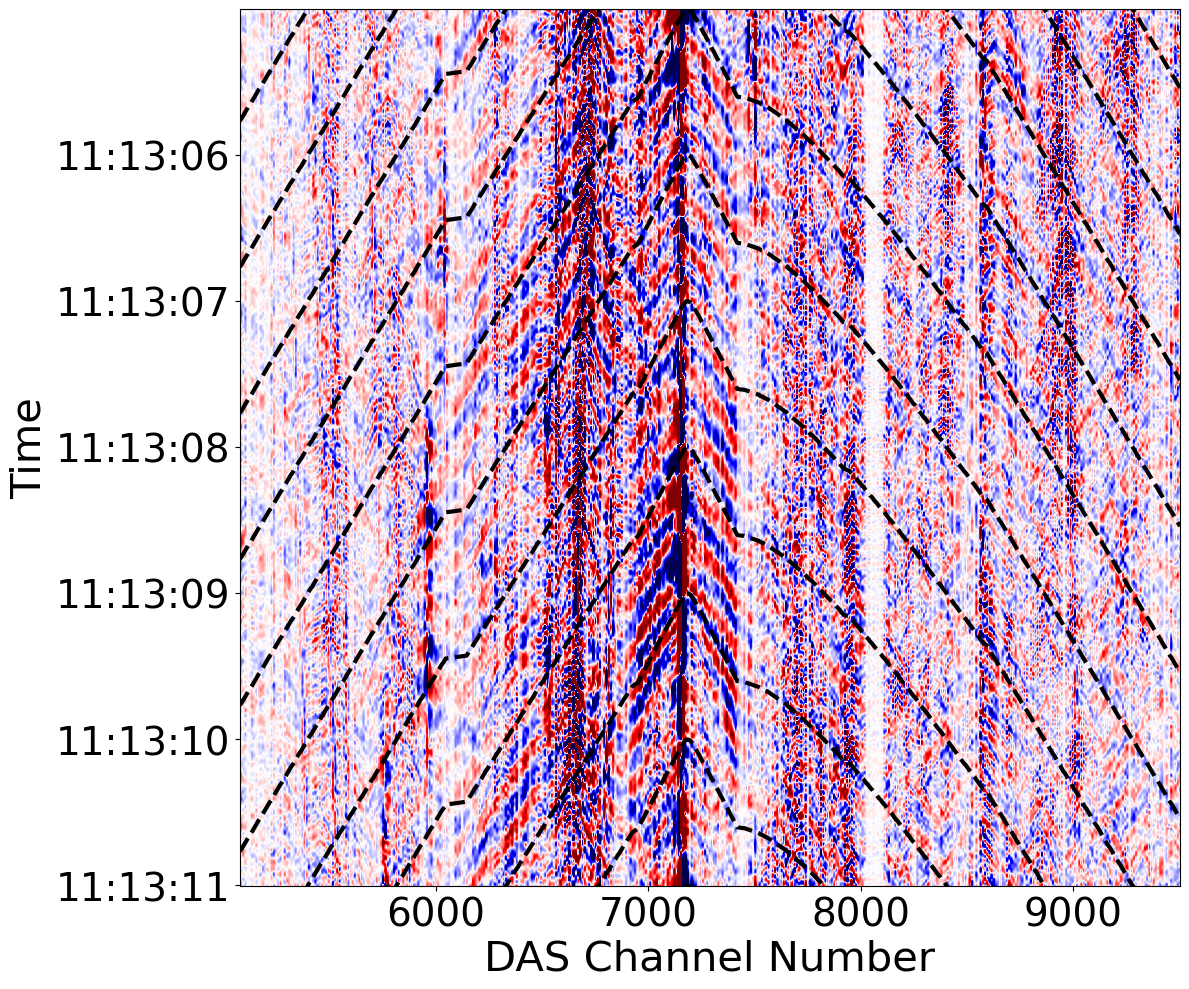

In [3]:
# Visualize the data and wavefield
plane_thr = 100
fs = 200
micgeofile = 'data/array_pos/DASArray_10T.xml'
mg = acoular.MicGeom(from_file=micgeofile)
bbox_width = np.load('data/array_pos/cha_save.npz')['bbox_width']
bbox_height = np.load('data/array_pos/cha_save.npz')['bbox_height']
rg = acoular.RectGrid(x_min=-bbox_width/2, x_max=bbox_width/2,
                      y_min=-bbox_height/2, y_max=bbox_height/2,
                      z=0, increment=50)
env = acoular.Environment()
distGridToAllMic = env._r(rg.pos(),mg.mpos)

_delays = delays(distGridToAllMic,c=370)
focus_channel = 18500
_start_time = datetime(2023, 9, 20, 11, 12, 35)
_end_time = _start_time + timedelta(minutes=1.10)
_start_channel = 16300
_end_channel = 21000
delay_idx = np.argmin(_delays[:,np.searchsorted(x_axis_pp, focus_channel)])
plot_time_series_w_delay(data_pp, x_axis_pp, t_axis_pp,
                        _delays[delay_idx,:]*fs,
                        start_channel = _start_channel,end_channel = _end_channel,
                        start_time=_start_time, end_time=_end_time)

# Beamforming for construction data

In [4]:
h5_file_path = f'data/das_data/const.h5'

freq_lb = 1
freq_up = 8
micgeofile = 'data/array_pos/DASArray_10T.xml'
freqs = np.load('data/vs/region3_v.npz')['freqs']
vels = np.load('data/vs/region3_v.npz')['vels']
f_c = interpolate.interp1d(freqs[(freqs>=freq_lb)&(freqs<=freq_up)],vels[(freqs>=freq_lb)&(freqs<=freq_up)])    
mg = acoular.MicGeom(from_file=micgeofile)
ts = acoular.MaskedTimeSamples(name=h5_file_path)
rg = acoular.RectGrid(x_min=-bbox_width/2, x_max=bbox_width/2,
                      y_min=-bbox_height/2, y_max=bbox_height/2,
                      z=0, increment=50)
env = acoular.Environment()

maps = []
ts.start = 60*200
ts.stop = 65*200-1
ps = acoular.PowerSpectra(time_data=ts, overlap='50%', block_size=256, window='Hanning',
                          ind_low=0, ind_high=10)
h,c = freq_beamformer_dyn(freq_lb, freq_up, f_c, plane_thr, rg, mg, env, ts, ps, 4, Q=14)
maps.append(h)
    
np.savez('data/const_maps.npz', maps=maps)

[('const_cache.h5', 1)]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

  0%|          | 0/4620 [00:00<?, ?it/s]

# Seismic source mapping
note: DAS channel coordinates are not provided.

/home/jingxiao/sjc_das/urban_das/modules/utils.py:1004: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(fontsize=20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/jingxiao/anaconda3/envs/das/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jingxiao/sjc_das/urban_das/modules/utils.py:1033: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgra

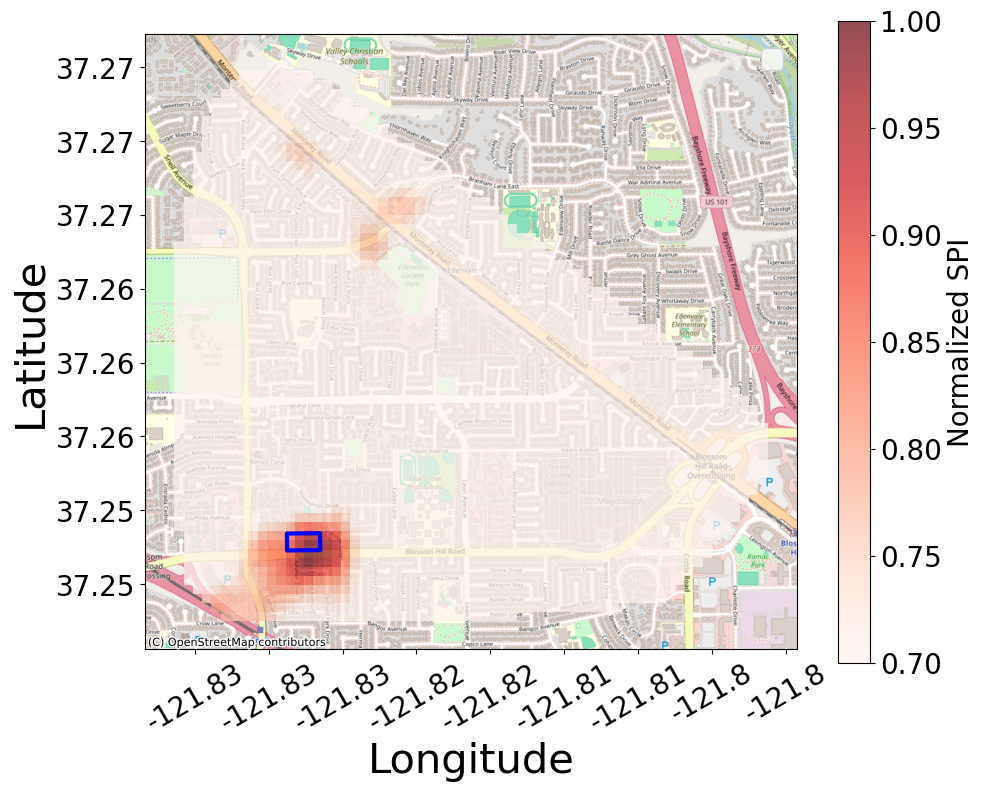

In [6]:
maps = np.load('data/const_maps.npz')['maps']
mask = np.load('data/mask_region3.npz')['mask']
bounds_gps = (-121.83583333333333,
             37.24638888888889,
             -121.79861111111111,
             37.276944444444446)
street_map = getImageCluster(bounds_gps[1], bounds_gps[0], bounds_gps[3]-bounds_gps[1],
                    bounds_gps[2]-bounds_gps[0], 17)

low_thr = 0.7
# Construction Location
with open('data/const_area.pickle', 'rb') as handle:
    const_area = pickle.load(handle)
object_params = [[const_area,'Construction site']]
for i in range(1):
    maps_const = acoular.L_p(maps[i])
    maps_const = gaussian_filter(maps_const, sigma=1)
    gdf_const = create_geodataframe(maps_const, mask, bounds_gps, crs='EPSG:4326')
    object_param = object_params[i]
    plot_heatmap(gdf_const, low_thr, boundary_params=object_param, figsize=(10,8))